
# Проект по анализу результатов A/B тестирования в крупном дейтинговом приложении

Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Необходимо проверить, был ли эксперимент успешен.

### Данные:
**Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2)**.<br />

Для каждой из них:

users_*.csv – информация о пользователях:

uid – идентификатор пользователя <br />
age – возраст<br />
attraction_coeff – коэффициент привлекательности (от 0 до 1000, {лайки}{просмотры}*1000 просмотры лайки∗1000)<br />
coins – число монеток (внутренняя валюта)<br />
country – страна  <br />
visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)<br />
gender – пол<br />
age_filter_start  – фильтр поиска, мин. значение <br />
age_filter_end  – фильтр поиска, макс. значение <br />
views_count – число полученных оценок <br />
was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)<br />
is_premium –  является ли премиум<br />
total_revenue – нормированная выручка <br />

transactions_*.csv – информация о платежах пользователей:

uid – идентификатор пользователя<br />
country – страна<br />
joined_at – дата и время регистрации<br />
paid_at – дата и время покупки<br />
revenue – нормированная выручка<br />
payment_id – идентификатор платежа<br />
from_page – откуда пользователь перешел на страницу оплаты<br />
product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) <br />

### Цель проекта и какие метрики будут использованы
Целью проведенного A/B теста (далее проекта) - оценить успешность изменения стоимости на premium подписку для новых пользователей из нескольких стран при покупке через две новые платежные системы.<br />

Нам неизвестно, была ли увеличена или снижена стоимость premium (платной) подписки<br />
1. Conversion Rate (CR) в премиум-подписку (предполагаю, что бизнес ожидает увеличение конверсии)<br />
2. ARPU & ARPPU (посмотрю, что происходит с выручкой, в том числе и от премиум-подписчиков)

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import requests 
from urllib.parse import urlencode
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, mannwhitneyu, chi2_contingency
import scipy
from tqdm.auto import tqdm
from scipy import stats

In [2]:
# функция для скачивания файлов с Яндекс-диска
def get_url_disk(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

In [3]:
# ссылки на файлы с данными
public_key_users_test = 'https://disk.yandex.ru/d/4XXIME4osGrMRA'
public_key_users_control_1 = 'https://disk.yandex.ru/d/yJFydMNNGkEKfg'
public_key_users_control_2 = 'https://disk.yandex.ru/d/br6KkQupzzTGoQ'
public_key_transactions_test = 'https://disk.yandex.ru/d/gvCWpZ55ODzs2g'
public_key_transactions_control_1 = 'https://disk.yandex.ru/d/VY5W0keMX5TZBQ'
public_key_transactions_control_2 = 'https://disk.yandex.ru/d/th5GL0mGOc-qzg'

In [4]:
# Импорт данных
#users_test = pd.read_csv(get_url_disk(public_key_users_test), sep=';')
#users_control_1 = pd.read_csv(get_url_disk(public_key_users_control_1), sep=';')
#users_control_2 = pd.read_csv(get_url_disk(public_key_users_control_2), sep=';')
#transactions_test = pd.read_csv(get_url_disk(public_key_transactions_test), sep=';')
#transactions_control_1 = pd.read_csv(get_url_disk(public_key_transactions_control_1), sep=';')
#transactions_control_2 = pd.read_csv(get_url_disk(public_key_transactions_control_2), sep=';')

In [5]:
# В случае, если яндекс-диск ругается на лимиты скачивания

users_test = pd.read_csv(r'C:\Users\yurkina_yv\Dating_Project\Проект_3_users_test.csv', sep=';')
users_control_1 = pd.read_csv(r'C:\Users\yurkina_yv\Dating_Project\Проект_3_users_control_1.csv', sep=';')
users_control_2 = pd.read_csv(r'C:\Users\yurkina_yv\Dating_Project\Проект_3_users_control_2.csv', sep=';')
transactions_test = pd.read_csv(r'C:\Users\yurkina_yv\Dating_Project\Проект_3_transactions_test.csv', sep=';')
transactions_control_1 = pd.read_csv(r'C:\Users\yurkina_yv\Dating_Project\Проект_3_transactions_control_1.csv', sep=';')
transactions_control_2 = pd.read_csv(r'C:\Users\yurkina_yv\Dating_Project\Проект_3_transactions_control_2.csv', sep=';')

####                                     Посмотрим на данные в группах

In [6]:
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [7]:
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [8]:
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [9]:
transactions_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [10]:
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [11]:
transactions_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [12]:
# Посмотрим на датасеты users

print(users_test.info())
print(users_control_1.info())
print(users_control_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column 

Есть пропущенные значения в coins, visit days и is_premium/was_premium. Предполагаю, что это объясняется поведением пользователей (не заходили в приложение после установки, не использовали внутреннюю валюту, не стали премуиум-подписчиками). Оставим всех.

In [13]:
# Посмотрим на датасеты transactions

print(transactions_test.info())
print(transactions_control_1.info())
print(transactions_control_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           273 non-null    int64 
 1   country       273 non-null    object
 2   joined_at     273 non-null    object
 3   paid_at       273 non-null    object
 4   revenue       273 non-null    int64 
 5   payment_id    273 non-null    int64 
 6   from_page     273 non-null    object
 7   product_type  273 non-null    object
dtypes: int64(3), object(5)
memory usage: 17.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country       377 non-null    object 
 2   joined_at     1007 non-null   object 
 3   paid_at       1007 non-null   object 
 4   revenue       377 non-null    float64
 5   payment_

In [14]:
# Посмотрим на уникальность uid

df_all = [users_test, users_control_1, users_control_2, transactions_test, transactions_control_1, transactions_control_2]
unique_all = []

for i in df_all:
    unique_all.append(i.uid.nunique())
print('Уникальных uid в датасетах:', unique_all)

Уникальных uid в датасетах: [4308, 4340, 4264, 146, 193, 187]


Видим, что количество уникальных uid различается, причем, в датасетах по пользователям их больше, чем в датасетах по совершенным транзакциям.

In [15]:
# Посмотрим на пропущенные uid

df_all = [users_test, users_control_1, users_control_2, transactions_test, transactions_control_1, transactions_control_2]
no_data = []

for i in df_all:
    no_data.append(i.uid.isna().sum())
print('Пропущенные uid в датасетах:', no_data)

Пропущенные uid в датасетах: [0, 0, 0, 0, 630, 0]


In [16]:
# Пропущенные uid только в датасете transactions_control_1. Удалим их и проверим

transactions_control_1 = transactions_control_1.query("uid != 'NaN'")
transactions_control_1.uid.isna().sum()

630

In [17]:
# Посмотрим на дубликаты

df_all = [users_test, users_control_1, users_control_2, transactions_test, transactions_control_1, transactions_control_2]
duplicates = []

for i in df_all:
    duplicates.append(i.loc[i.duplicated()].shape[0])
print(duplicates)

[0, 0, 0, 7, 650, 5]


Дубликаты есть только в датасетах с транзакциями. Удалим их.

In [18]:
transactions_test = transactions_test.drop_duplicates()
transactions_control_1 = transactions_control_1.drop_duplicates()
transactions_control_2 = transactions_control_2.drop_duplicates()

### Объединим датасеты

Объединим данные users в одну таблицу: <br />

А1 - users_control_1 <br />
А2 - users_control_2 <br />
В - users_test <br />

In [19]:
# присвоим тестовой группе название B, контрольным - A1 и A2
users_test['group'] = 'B'
users_control_1['group'] = 'A1'
users_control_2['group'] = 'A2'
users = pd.concat([users_test, users_control_1, users_control_2])

In [20]:
users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,B
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,B
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,B
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,B
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,B


In [21]:
# Проверим,все ли данные присоединены
users.group.value_counts()

A1    4340
B     4308
A2    4264
Name: group, dtype: int64

Объединим данные transactions в одну таблицу:

А1 - transactions_control_1 <br />
А2 - transactions_control_2 <br />
B - transaction_test

In [22]:
transactions_test['group'] = 'B'
transactions_control_1['group'] = 'A1'
transactions_control_2['group'] = 'A2'
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2])

C:\Users\yurkina_yv\AppData\Local\Temp\ipykernel_17160\1027004186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_test['group'] = 'B'
C:\Users\yurkina_yv\AppData\Local\Temp\ipykernel_17160\1027004186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_control_1['group'] = 'A1'
C:\Users\yurkina_yv\AppData\Local\Temp\ipykernel_17160\1027004186.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [23]:
# сбросим индексы
if transactions[transactions.index.duplicated()].shape[0] != 0:
    transactions = transactions.reset_index()
    transactions.drop('index', axis=1, inplace=True)

In [24]:
transactions.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,B
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,B
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,B
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,B
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,B


In [25]:
# Проверим,все ли данные присоединены
transactions.group.value_counts()

A1    357
A2    323
B     266
Name: group, dtype: int64

### Обработка данных users:

In [26]:
# поменяем тип данных
users = users.astype({'uid': 'str'})

In [27]:
# проверим
users.dtypes

uid                  object
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
group                object
dtype: object

In [28]:
# посмотрим, из какого количества стран пользователи

df_all = [users_test, users_control_1, users_control_2]
unique_country = []

for i in df_all:
    unique_country.append(i.country.nunique())
print('Из какого количества стран:', unique_country)

Из какого количества стран: [51, 40, 45]


Т.к. стоимость премиум-подписки была изменена только в некоторых странах, то оставим лишь те страны, которые есть в тестовой группе и содержат хотя бы по одному представителю в каждой из групп

In [29]:
df = users.groupby(['country', 'group'], as_index=False).agg({'uid': 'count'}).rename(columns = {'uid': 'amount'})
pivot = df.pivot_table(index='country', columns='group', values='amount', fill_value=0).reset_index()
pivot.head(10)

group,country,A1,A2,B
0,Algeria,2,0,2
1,Argentina,389,397,396
2,Armenia,1,0,0
3,Australia,50,51,62
4,Austria,0,2,0
5,Azerbaijan,0,0,1
6,Belarus,0,1,0
7,Belgium,108,90,92
8,Bolivia,0,0,1
9,Brazil,0,0,1


In [30]:
countries = list(pivot.query('A1!=0 and A2!=0 and B!=0').country)

In [31]:
users = users.query('country in @countries')
users.group.value_counts()

A1    4319
B     4271
A2    4238
Name: group, dtype: int64

Посмотрим на характеристики 'was_premium' и 'is_premium'

In [32]:
users.query('is_premium == 1 and was_premium != 1').count()[0]

0

In [33]:
users.query('was_premium == 1 and is_premium != 1').count()[0]

712

Получается, что все 'is_premium' == 1 были 'was_premium'. Таким образом, будем ориентироваться только на was_premium и переименуем его 

In [34]:
users.rename(columns={'was_premium':'premium'}, inplace=True)
users['premium'] = users['premium'].fillna(0)
users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,premium,is_premium,total_revenue,group
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,NaN,0,B
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,0.0,NaN,0,B
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,NaN,0,B
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,NaN,0,B
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,B


Таким образом,, 712 пользователей были или являются премиум-подписчиками

Посмотрим на пользователей в разрезе их "премиальности"

In [35]:
# премиум-платящие пользователи

users.query('premium == 1 and total_revenue > 0').count()[0]

491

In [36]:
# премиум не-платящие пользователи

users.query('premium == 1 and total_revenue == 0').count()[0] # вероятно они пробовали бесплатный-премиум

758

In [37]:
# выручка премиум-пользователей

users.query('premium == 1 and total_revenue > 0').total_revenue.sum()

6587555

In [38]:
# выручка остальных пользователей

users.query('premium == 0 and total_revenue > 0').total_revenue.sum()

179933

Выделим группы соответствующие группы

In [39]:
def user_type(premium, total_revenue):
    if premium == 1 and total_revenue != 0:
        return 'premium_pay'
    elif premium == 1 and total_revenue == 0:
        return 'premium_not_pay'
    elif premium == 0 and total_revenue != 0:
        return 'not_premium_pay'
    else:
        return 'not_premium_not_pay'

In [40]:
users['user_type'] = users.apply(lambda x: user_type(x.premium, x.total_revenue), axis=1)

In [41]:
users.user_type.value_counts().to_frame().reset_index().rename(columns={'index': 'type'})

,type,user_type
0,not_premium_not_pay,11548
1,premium_not_pay,758
2,premium_pay,491
3,not_premium_pay,31


В дальнейшем мы воспользуемся этой информацией

### Обработка данных transactions:

In [42]:
# поменяем тип данных
transactions = transactions.astype({'uid': 'str'})
transactions.joined_at = pd.to_datetime(transactions.joined_at)
transactions.paid_at = pd.to_datetime(transactions.paid_at)

In [43]:
# проверим
transactions.dtypes

uid                     object
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                float64
payment_id             float64
from_page               object
product_type            object
group                   object
dtype: object

Уберем .0 в uid, т.к в users идет без нулей

In [44]:
transactions.uid = transactions.uid.apply(lambda x: x.split('.')[0])

Посмотрим на даты подключения пользователей и оплаты

In [45]:
df_all = [transactions_test, transactions_control_1, transactions_control_2]
min_joined = []

for i in df_all:
    min_joined.append(i.joined_at.min())
print('Минимальная дата подключения по группам:', min_joined)

Минимальная дата подключения по группам: ['2017-01-11 03:07:00', '2015-01-19 11:49:00', '2017-01-11 08:36:00']


In [46]:
df_all = [transactions_test, transactions_control_1, transactions_control_2]
max_joined = []

for i in df_all:    
    max_joined.append(i.joined_at.max())
print('Максимальная дата подключения по группам:', max_joined)

Максимальная дата подключения по группам: ['2017-10-31 23:40:00', 'NaT', '2017-10-31 17:43:00']


In [47]:
df_all = [transactions_test, transactions_control_1, transactions_control_2]
min_paid = []

for i in df_all:
    min_paid.append(i.paid_at.min())
print('Минимальная дата оплаты по группам:', min_paid)

Минимальная дата оплаты по группам: ['2017-01-11 04:37:00', '2016-12-14 16:16:00', '2017-01-11 05:34:00']


In [48]:
df_all = [transactions_test, transactions_control_1, transactions_control_2]
max_paid = []

for i in df_all:
    max_paid.append(i.paid_at.max())
print('Максимальная дата оплаты по группам:', max_paid)

Максимальная дата оплаты по группам: ['2017-12-11 22:06:00', 'NaT', '2017-12-11 23:28:00']


Оставим в датасете одинаковый для всех период эксперимента

In [49]:
transactions = transactions.query('joined_at >= "2017-01-11 00:00:00"')

Text(0.5, 1.0, 'Распределение платежей по датам оплаты')

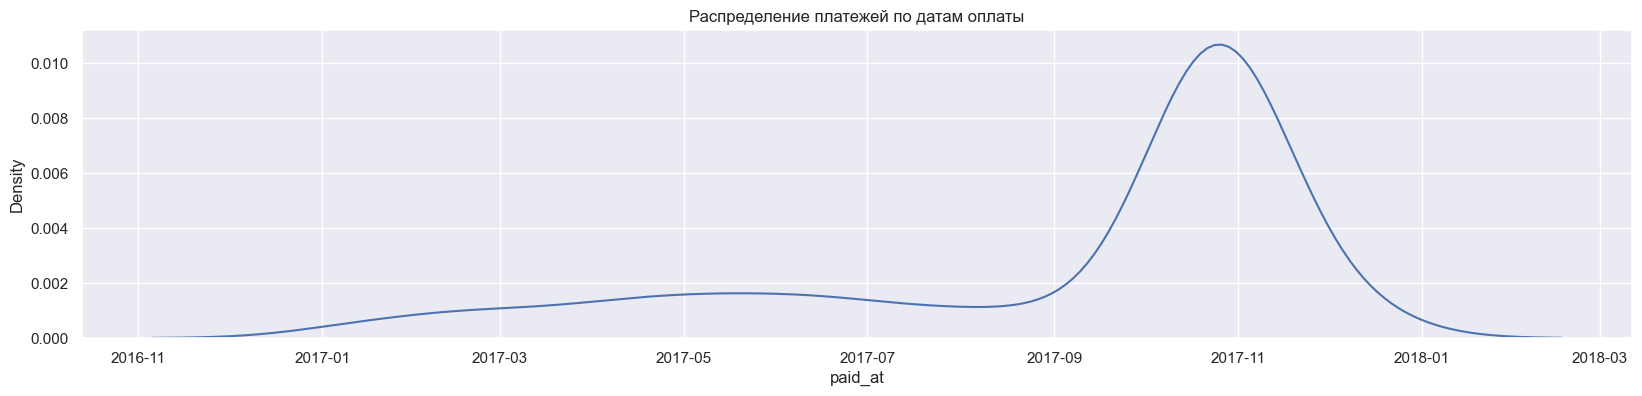

In [50]:
sns.set(rc={'figure.figsize': (20, 4)})
sns.kdeplot(data=transactions, x="paid_at")\
    .set_title("Распределение платежей по датам оплаты")

In [51]:
# посчитаем количество оплат на каждого пользователя
payments = (transactions.groupby('uid', as_index=False)
                        .agg({'revenue': 'count'})
                        .rename(columns={'revenue': 'payment'})
                        .sort_values('payment', ascending=False))
                        
                        
payments

,uid,payment
483,892333905,19
369,892069554,11
452,892236423,11
196,891637005,11
231,891707061,10
...,...,...
204,891654012,1
203,891653790,1
202,891651711,1
201,891648354,1


Есть пользователи, которые совершали платеж не один раз. Интересно посмотреть на лидера.

In [52]:
transactions.query('uid == "892333905"').sort_values('paid_at', ascending=True)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
314,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:42:00,3783.0,67.0,menu,other_type,A1
279,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,A1
294,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type,A1
309,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type,A1
272,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,12610.0,19.0,gifts,coins,A1
400,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,31525.0,19.0,gifts,coins,A1
542,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,3783.0,67.0,gifts,other_type,A1
412,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,1261.0,19.0,gifts,coins,A1
549,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:26:00,31525.0,19.0,menu,coins,A1
563,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:52:00,31525.0,19.0,menu,coins,A1


Это пользователь из контрольной группы, который подключился 16.10, а покупки совершал 16 и 17.10, после чего не заходил в приложение. Время покупки - похоже (у некоторых с разницей в секунды). Одна из страниц, с которых переходил на оплату пользователь - empty_admins, что наводит на мысль, что это транзакции разработчиков

In [53]:
# посмотрим, с каких страниц заходили пользователи на оплату

transactions.groupby(['from_page', 'product_type']).agg({'uid':'count'}).sort_values(['from_page','uid', 'product_type'], ascending=False)

uid
from_page           product_type         
user_profile        premium_no_trial    4
                    trial_premium       1
trial_vip_popup     trial_premium     149
sympathy            other_type          7
super_popup         other_type          4
send_message        premium_no_trial    6
                    trial_premium       2
promo_09            premium_no_trial   58
                    trial_premium       3
popular_users_chat  premium_no_trial   13
                    trial_premium       2
popular_users_block premium_no_trial   18
                    trial_premium       1
none                premium_no_trial   53
                    coins              39
                    other_type          5
                    trial_premium       3
no_sympathy         premium_no_trial    2
menu                coins              49
                    other_type         17
likes               coins               1
left_sidebar_menu   premium_no_trial   45
                    trial_premium       2
gifts               coins              14
                    other_type          4
fans                other_type          6
                    premium_no_trial    4
                    coins               4
empty_mutual        other_type          2
empty_likes         coins             196
                    other_type         58
empty_admins        other_type          2
delivery_vip        premium_no_trial    1
dating              premium_no_trial   18
                    trial_premium       6
coins_popup         other_type          3
autoreply_message   premium_no_trial   67
                    trial_premium      13
autorefill          coins              48
admins              other_type          2
ad_to_photo         coins               7
                    other_type          3

Также есть пользователи, которые покупали со страницы admins. Возможно, это также транзакции разработчиков

In [54]:
transactions.query('from_page == "empty_admins"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
294,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type,A1
309,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type,A1


In [55]:
transactions.query('from_page == "admins"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
478,892019337,France,2017-10-22 19:27:00,2017-10-29 18:41:00,2314.0,67.0,admins,other_type,A1
520,891989511,United States of America,2017-10-23 11:34:00,2017-10-26 17:09:00,1625.0,67.0,admins,other_type,A1


Поскольку мы наверняка не знаем, что эти транзакции разработчиков, оставим их для дальнейшего анализа

Предположим, что payment_id это данные платежной системы. Посмотрим разброс данных, поскольку сказано, что стоимость премиум-подписки была изменена только на 2х платежных системах

In [56]:
print(transactions_test.payment_id.unique())
print(transactions_control_1.payment_id.unique())
print(transactions_control_2.payment_id.unique())

[147  67  19 146  68   0]
[147.  19. 127. 146.  67.  68.   0.  nan]
[ 19 147  67  68 146   0]


In [57]:
# Посмотрим, какие платежи совершались через payment_id 127

transactions_control_1.query('payment_id == 127')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type,A1
200,891367521.0,Italy,2017-05-11 02:37:00,2017-10-11 01:52:00,1469.0,127.0,coins_popup,other_type,A1
257,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 17:43:00,1456.0,127.0,sympathy,other_type,A1


Это единственный пользователель, который покупал какие-то другие продукты в приложении, в покупке премиум-подписки он не участвовал. Не будем его исключать из анализа.

In [58]:
# Посмотрим на количество платежей по каждой из платежных систем

test_payments = transactions_test \
    .groupby('payment_id', as_index=False) \
    .agg({'uid' : 'count'}) \
    .rename(columns={'uid': 'test_payments'})

c1_payments = transactions_control_1 \
    .groupby('payment_id', as_index=False) \
    .agg({'uid' : 'count'}) \
    .rename(columns={'uid': 'c1_payments'})

c2_payments = transactions_control_2 \
    .groupby('payment_id', as_index=False) \
    .agg({'uid' : 'count'}) \
    .rename(columns={'uid': 'c2_payments'})

all_paysystem = pd.merge(pd.merge(test_payments, c1_payments, on='payment_id', how = 'left'),
                         c2_payments, on='payment_id', how = 'left')

all_paysystem

,payment_id,test_payments,c1_payments,c2_payments
0,0,1,5,1
1,19,74,108,91
2,67,22,35,42
3,68,14,18,14
4,146,30,32,30
5,147,125,155,145


Больше всего оплат было через системы 19 и 147. Возможно, именно для этих платежных систем была изменена стоимость премиум-подписки

На платформе несколько типов покупок - посмотрим на них

In [59]:
transactions.groupby('product_type').agg({'uid': 'count'})

,uid
product_type,
coins,358
other_type,113
premium_no_trial,289
trial_premium,182


In [60]:
transactions.groupby('product_type').agg({'revenue': 'sum'})

,revenue
product_type,
coins,1735370.0
other_type,447174.0
premium_no_trial,2334774.0
trial_premium,2216903.0


Бизнес получает доход не только от премиум-подписчиков, но и от покупки пользователями других продуктов. Но нас будет интересовать только доход от премиум-подписки, поскольку по условия именно её стоимость поменялась

In [61]:
# посмотрим на количество транзакций по типу продукта
transactions.groupby('product_type').agg({'uid':'count'}).sort_values('product_type', ascending=False)

,uid
product_type,
trial_premium,182
premium_no_trial,289
other_type,113
coins,358


In [62]:
# посмотрим на количество уникальных пользователей по типу продукта
transactions.groupby('product_type').agg({'uid':'nunique'}).sort_values('product_type', ascending=False)

,uid
product_type,
trial_premium,181
premium_no_trial,268
other_type,81
coins,186


Количество транзакций и уникальных пользователей по premium_no_trial различается, значит, кто-то несколько раз покупал премиум-подписку. Далее при расчете конверсии учтем этот факт и будем брать только первую покупку премиум

Для дальнейшего анализа к таблице transactions присоединим user_type

In [63]:
user_type = users.groupby('uid', as_index=False).agg({'user_type': 'min'})
user_type.head()

,uid,user_type
0,1053059022,premium_not_pay
1,891050916,not_premium_not_pay
2,891050997,not_premium_not_pay
3,891051075,not_premium_not_pay
4,891051147,not_premium_not_pay


In [64]:
transactions = transactions.merge(user_type, how='left', on='uid')

In [65]:
# посмотрим на количество уникальных пользователей по типу продукта и user_type
transactions.groupby(['user_type','product_type']).agg({'uid':'nunique'}).sort_values('uid', ascending=False)

uid
user_type       product_type         
premium_pay     premium_no_trial  266
                trial_premium     180
                coins             160
                other_type         71
not_premium_pay coins              24
                other_type          9
premium_not_pay other_type          1

In [66]:
# посмотрим на сумму выручки по типу продукта и user_type

transactions.groupby(['user_type','product_type']).agg({'revenue':'sum'}).sort_values('revenue', ascending=False)

revenue
user_type       product_type               
premium_pay     premium_no_trial  2324361.0
                trial_premium     2204137.0
                coins             1590524.0
                other_type         385866.0
not_premium_pay coins              133926.0
                other_type          31044.0
premium_not_pay other_type          30264.0

"Премиальные" подписчики покупали разные продукты, обычные пользователи - только coins и other_type. И есть один странный пользователь из категории "премиальных", у которого нет данных по оплате в пользователях, но есть выручка в транзакциях. Посмотрим на него.

In [67]:
users.query('uid == "892355163"')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,premium,is_premium,total_revenue,group,user_type
3370,892355163,40,640,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,1.0,NaN,0,A1,premium_not_pay


In [68]:
transactions.query('uid == "892355163"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,user_type
550,892355163,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68.0,super_popup,other_type,A1,premium_not_pay


Предполагаю, что это проблема качества данных, и его нужно удалить для дальнейшего анализа из обеих таблиц

In [69]:
users = users.query('uid != "892355163"')
transactions = transactions.query('uid != "892355163"')

In [70]:
# посмотрим на выручку в обеих таблицах

print(f'Сумма по total_revenue', users.total_revenue.sum())
print(f'Сумма по revenue', transactions.revenue.sum())

Сумма по total_revenue 6767488
Сумма по revenue 6703957.0


Данные по выручке различаются в пользу total_revenue. Предполагаю, что в таблице users или неверные данные или данные больше, чем за период эксперимента.

In [71]:
# посчитаем общую выручку по каждому пользователю

revenue_transactions = transactions.groupby('uid', as_index = False) \
                                  .agg({'revenue':'sum'})

In [72]:
#объединим users с датасетом по выручке и пустые значения заполним нулями

users_transactions = users.merge(revenue_transactions, how='left', on='uid').fillna(0)

In [73]:
# Проверим, не изменилось ли количество строк в таблицах

print('Количество строк и столбцов до объединения:',
      users.shape, 'После объединения:', users_transactions.shape)

Количество строк и столбцов до объединения: (12827, 15) После объединения: (12827, 16)


In [74]:
# посмотрим, у кого есть расхождения в total_revenue и revenue (не считая предыдущего пользователя, которого удалили)
    
erorrs = users_transactions.query('total_revenue != revenue')
erorrs.uid.nunique() 

21

In [75]:
erorrs.groupby('group', as_index=False).uid.count()

,group,uid
0,A1,11
1,A2,5
2,B,5


Таких оказалось немного, больше всего в первой контрольной группе. Поэтому для анализа будем использовать выручку revenue.

### Итоги по изучению и обработки данных

1. Были удалены пропущенные значения и дубликаты
2. Исключены из анализа даты, которые выбиваются из эксперимента
3. Оставили лишь те страны, которые есть в тестовой группе и содержат хотя бы по одному представителю в каждой из групп
3. Проанализированы платежные системы, покупаемые продукты и страницы, с которых заходили пользователи для оплаты.
4. Проанализированы транзакции по типу продукта и пользователи по их "премиальности". Иключили из анализа сомнительного пользователя
5. Сравнили выручку в обеих таблицах, нашли расхождения.

## Проведение А/А и A/B тестирований

Не уверена, что нужно убирать пользователей с несовпавшей выручкой из дальнейшего анализа, или заменять значения. Оставлю как есть

### А/A тестирование

Посмотрим на харатеристики и качество сплитования групп. Для чистоты эксперимента выборки должны быть однородными - будем использовать страны, пол, возраст для оценки репрезентативности выборок (мы можем взять их из анкеты пользователей)

Распределение по странам

In [76]:
df = users.groupby(['country', 'group'], as_index=False).agg({'uid': 'count'})

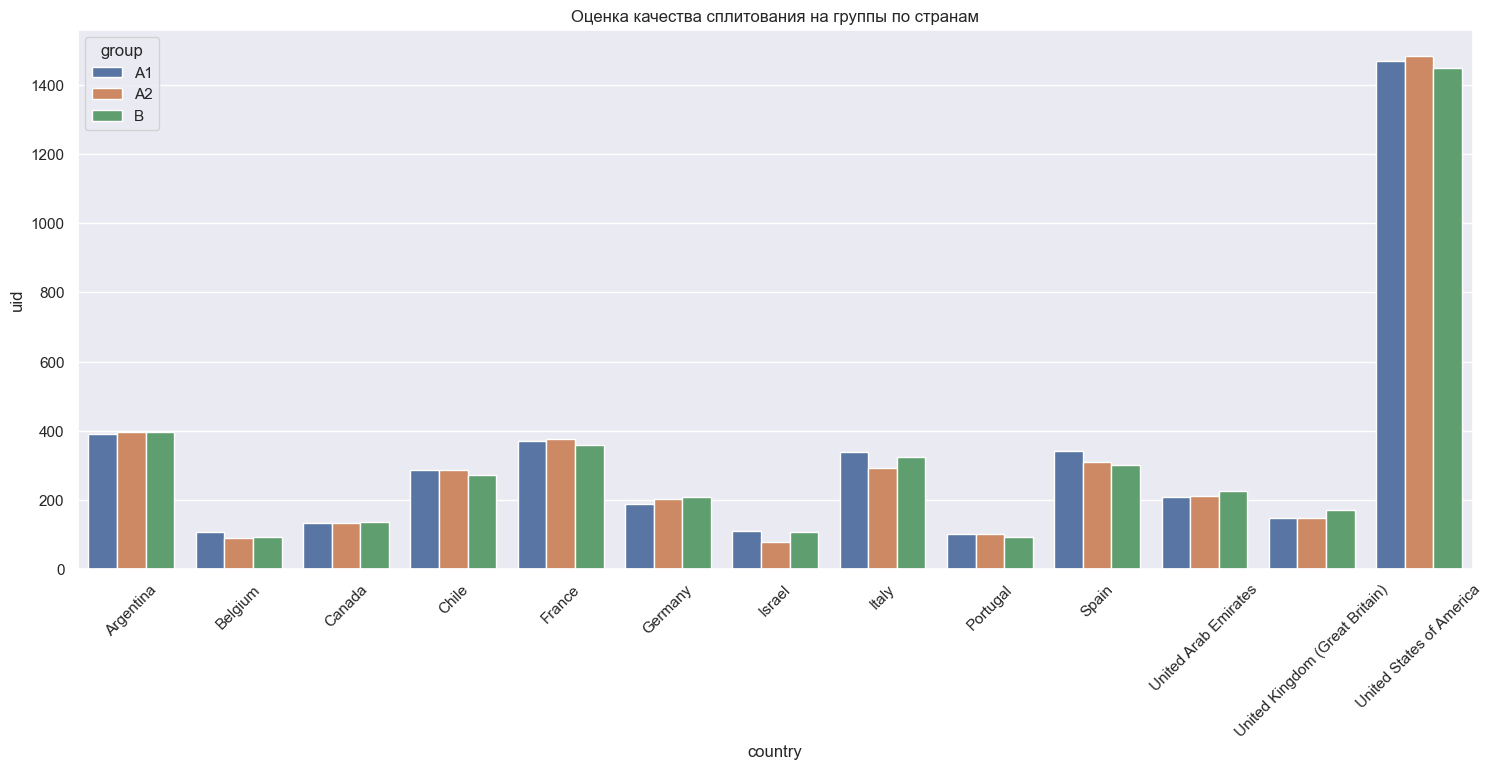

In [77]:
sns.set(rc={'figure.figsize': (18, 7)})
sns.barplot(data=df.query('uid > 70'), x="country", y='uid', hue="group")\
    .set_title("Оценка качества сплитования на группы по странам")
plt.xticks(rotation=45)
plt.show()

##### По полу

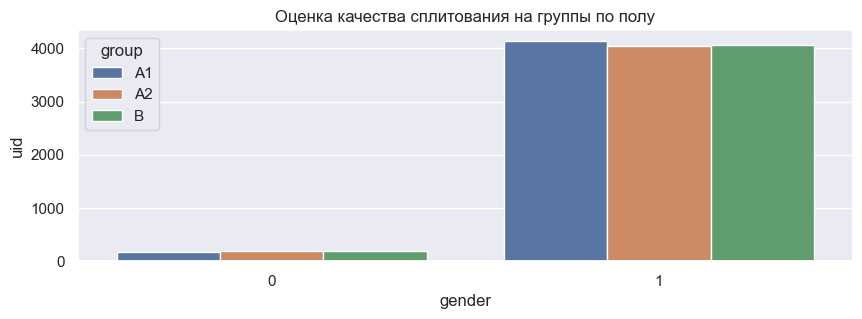

In [78]:
sns.set(rc={'figure.figsize': (10, 3)})
df = users.groupby(['gender', 'group'], as_index=False).agg({'uid': 'count'})
sns.barplot(data=df.query('uid > 70'), x="gender", y='uid', hue="group")\
    .set_title("Оценка качества сплитования на группы по полу")
plt.show()

Проверим через хи-квадрат, т.к. это категориальные переменные

**Гипотезы:**

H0 - различие в группах статистически не значимы

H1 - различие в группах статистически значимы

Если p_value < 0.05, то отклоняем H0, принимаем H1

In [79]:
# Создадим таблицу сопряженности
tab_gender = pd.crosstab(users.gender, users.group)
tab_gender

group,A1,A2,B
gender,,,
0,182,194,200
1,4136,4044,4071


In [80]:
g, p, dof, expctd = chi2_contingency(tab_gender)
print('р уровень значимости равен:', p)

р уровень значимости равен: 0.5467066039524145


P-value больше 0,05, таким образом, мы не можем принять H1, т.е. группы по полу не отличаются

#### По возрасту

Сначала разобьем на возрастные группы

In [81]:
# посмотрим на возраст в группах
ages_describe = users.groupby('group').age.describe()
ages_describe

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A1,4318.0,32.084067,10.264608,16.0,24.0,30.0,38.0,99.0
A2,4238.0,32.041529,10.146888,16.0,25.0,30.0,38.0,99.0
B,4271.0,31.903770,10.269227,16.0,25.0,30.0,38.0,99.0


Таким образом, сделаем минимальный возраст 16 лет, а максимальный 99.

In [82]:
labels = ['16_20', '21_30', '31_40', '41_50', '51_99']
bins = [15, 20, 30, 40, 50, 99]

users_age = users.assign(age_group=pd.cut(users['age'], bins=bins, labels=labels))
users_age.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,premium,is_premium,total_revenue,group,user_type,age_group
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,NaN,0,B,not_premium_not_pay,21_30
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,0.0,NaN,0,B,not_premium_not_pay,21_30
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,NaN,0,B,not_premium_not_pay,41_50
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,NaN,0,B,not_premium_not_pay,31_40
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,B,premium_not_pay,21_30


In [83]:
users_age = users_age.astype({'uid':'str'})

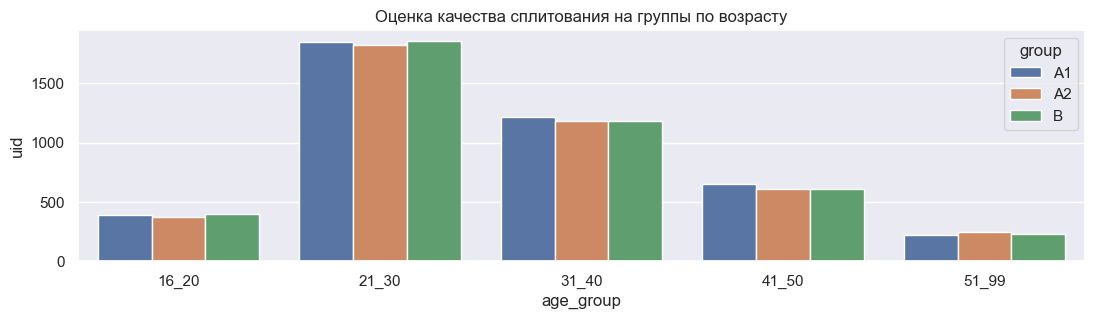

In [84]:
sns.set(rc={'figure.figsize': (13, 3)})
df = users_age.groupby(['age_group', 'group'], as_index=False).agg({'uid':'count'})
sns.barplot(data=df.query('uid > 70'), x="age_group", y='uid', hue="group").set_title("Оценка качества сплитования на группы по возрасту")
plt.show()

In [85]:
tab_age = pd.crosstab(users_age.age_group, users_age.group)
tab_age

group,A1,A2,B
age_group,,,
16_20,387,376,399
21_30,1845,1823,1855
31_40,1214,1185,1181
41_50,650,612,606
51_99,222,242,230


In [86]:
g, p, dof, expctd = chi2_contingency(tab_age)
print('р уровень значимости равен:', p)

р уровень значимости равен: 0.9021951841386582


P-value больше 0,05, таким образом, мы не можем принять H1, т.е. группы по возрасту не отличаются

Итак, можно утверждать, что группы достаточно однородны по полу, возрасту и странам.

### Вернемся к метрикам

1. CR в премиум-подписку<br />
2. ARPU & ARPPU
3. ARPU & ARPPU по premium_no_trial

**1. CR пользователя в премиум-подписку (в покупку premium_no_trial)**

In [87]:
# Для каждого пользователя отберем только первую покупку premium_no_trial
first_premium = transactions.query("product_type=='premium_no_trial'") \
    .groupby('uid', as_index=False) \
    .agg(first_premium=('paid_at', 'min'))

In [88]:
first_premium

,uid,first_premium
0,891068079,2017-12-11 15:23:00
1,891071157,2017-10-11 16:37:00
2,891077727,2017-10-11 16:33:00
3,891092322,2017-10-11 01:18:00
4,891112263,2017-11-11 14:55:00
...,...,...
263,892405224,2017-10-15 13:08:00
264,892421277,2017-10-15 13:11:00
265,892426491,2017-10-15 22:39:00
266,892434141,2017-10-14 04:23:00


In [89]:
# Первую покупку premium_no_trial обозначим  как 1

first_premium['purchase_premium'] = 1

In [90]:
# Объединим таблицы users и first_premium

users_transactions_premium = users_transactions.merge(first_premium, how='left', on='uid')

In [91]:
# Заменим пропущенные значения  в колонке 'purchase_premium' на 0

users_transactions_premium['purchase_premium'] = users_transactions_premium.purchase_premium.fillna(0)

In [92]:
users_transactions_premium.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,premium,is_premium,total_revenue,group,user_type,revenue,first_premium,purchase_premium
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,B,not_premium_not_pay,0.0,NaT,0.0
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,B,not_premium_not_pay,0.0,NaT,0.0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,B,not_premium_not_pay,0.0,NaT,0.0
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,B,not_premium_not_pay,0.0,NaT,0.0
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,B,premium_not_pay,0.0,NaT,0.0


In [93]:
# Посчитаем CR в %

conversion_control = users_transactions_premium.query('group != "B"') \
    .groupby('group', as_index=False) \
    .agg({'purchase_premium': 'mean'}) \
    .rename(columns={'purchase_premium': 'conversion'})

conversion_control['conversion'] = conversion_control.conversion.apply(lambda x: round(x * 100, 3))
conversion_control

,group,conversion
0,A1,2.293
1,A2,2.383


Конверсия отличается, проверим статистическую значимость различий

Будем использовать критерий Хи-квадрат, т.к. конверсия является категориальной переменной<br/>

**Гипотезы:**

H0 - различие CR в группах статистически не значимо

H1 - различие CR в группах статистически значимо

Если p_value < 0.05, то отклоняем H0, принимаем H1

In [94]:
tabAA = pd.crosstab(users_transactions_premium[users_transactions_premium['group'] != 'B'].purchase_premium, users_transactions_premium[users_transactions_premium['group'] != 'B'].group)
tabAA

group,A1,A2
purchase_premium,,
0.0,4219,4137
1.0,99,101


In [95]:
g, p, dof, expctd = chi2_contingency(tabAA)
print('р уровень значимости равен:', p)

р уровень значимости равен: 0.8372867495918012


P-value больше 0,05, таким образом, мы не можем принять H1, что отличие CR в группах статистически значимо

**2. ARPU & ARPPU**

In [96]:
ARPU = users_transactions.query('group != "B"').groupby('group', as_index=False).agg(ARPU=('revenue', 'mean'))
ARPU['ARPU'] = ARPU.ARPU.apply(lambda x: round(x, 3))
ARPU

,group,ARPU
0,A1,570.573
1,A2,444.328


In [97]:
ARPPU = transactions.query('group != "B"').groupby('group', as_index=False).agg(ARPPU=('revenue', 'mean'))
ARPPU['ARPPU'] = ARPPU.ARPPU.apply(lambda x: round(x, 3))
ARPPU

,group,ARPPU
0,A1,6999.244
1,A2,5907.111


Значения ARPU & ARPPU различны. Нужно проверить статистическую значимость этих отличий

Метрики ARPU и ARPPU являются количественными. Эти метрики показывают выручку на 1го пользователя и выручку на 1го платящего пользователя, т.е. по сути это метрики среднего.

Для выбора статистического критерия посмотрим на гомогенность и нормальность распределения

In [98]:
# проверяем гомогенность (т.е разброс значений)

scipy.stats.levene(transactions.query('group == "A1"').revenue, 
          transactions.query('group == "A2"').revenue, center='mean')

LeveneResult(statistic=3.9402011447545147, pvalue=0.04755069259710465)

Так как p-value меньше 0,05, то гипотеза о равенстве дисперсий неверна

In [99]:
# проверяем нормальность распределения
transactions_A1 = transactions.query('group == "A1"').revenue
stats.normaltest(transactions_A1)

NormaltestResult(statistic=340.06337869193686, pvalue=1.432766994150907e-74)

In [100]:
# проверяем нормальность распределения
transactions_A2 = transactions.query('group == "A2"').revenue
stats.normaltest(transactions_A2)

NormaltestResult(statistic=455.890526290961, pvalue=1.0107180925323713e-99)

**2. ARPU & ARPPU по подписке premium_no_trial**

Для ARPU по подписке premium_no_trial будем использовать таблицу users_transactions_premium (которую использовали для расчета конверсии)

In [101]:
ARPU_premium = users_transactions_premium.query('group != "B" and purchase_premium == 1').groupby('group', as_index=False).agg(ARPU=('revenue', 'mean'))
ARPU_premium['ARPU'] = ARPU_premium.ARPU.apply(lambda x: round(x, 3))
ARPU_premium

,group,ARPU
0,A1,14840.879
1,A2,9956.069


Для расчета ARPPU возьмем выручку только по premium_no_trial

In [102]:
ARPPU_premium = transactions.query('group != "B" and product_type == "premium_no_trial"').groupby('group', as_index=False).agg(ARPPU=('revenue', 'mean'))
ARPPU_premium['ARPPU'] = ARPPU_premium.ARPPU.apply(lambda x: round(x, 3))
ARPPU_premium

,group,ARPPU
0,A1,7351.500
1,A2,6960.832


ARPU и ARPPU по подписке premium_no_trial также различаются, будем проверять стат.значимость

Распределение выручки отличается от нормального, а также имеет значительные выбросы. Учитывая большой размер выборки, использование t-test при таком распределении все возможно, или в качестве альтернативы можно взять вариант t-testа - критерий Уэлча. Но в данном случае я бы хотела использовать непараметрический bootstrap, который хорош для неравных дисперсий и ненормальных распределений, т.к. может предоставить более точные оценки и позволяет оценивать распределение параметров на основе повторной выборки из оригинальных наблюдений

**Гипотезы:**

H0 - различие APRU/ARPPU в группах статистически не значимо

H1 - различие APRU/ARPPU в группах статистически значимо

Если p_value > 0.05, то статистическая разница между двумя группами не является статистически значимой, т.е наблюдаемые различия между группами могут быть случайными, и нет оснований считать, что эти различия существуют в действительности.

In [103]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

# Из лекции А.Карпова

# В полученных подвыборках будем считать среднее

In [104]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it = 1000,  # количество бутстрэп-подвыборок
    statistic = np.mean,  # интересующая нас статистика
    bootstrap_conf_level = 0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,  # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

ARPU

In [105]:
# ARPU

sample_1 = users_transactions.query('group == "A1"').revenue
sample_2 = users_transactions.query('group == "A2"').revenue

  0%|          | 0/1000 [00:00<?, ?it/s]

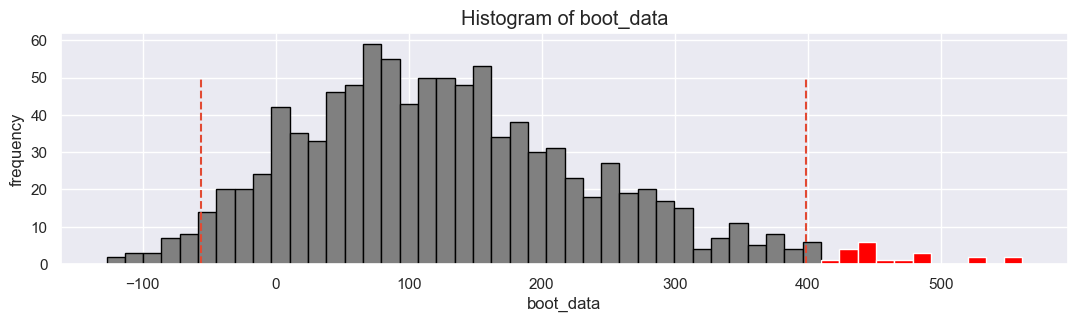

In [106]:
booted_data = get_bootstrap(sample_1, sample_2)  # в результате хранится разница двух распределений, доверительные интервалы и pvalue

In [107]:
booted_data['quants']  # Доверительные интервалы (далее ДИ)

,0
0.025,-55.820669
0.975,398.815343


In [108]:
booted_data['p_value']  # альфа

0.2559648226374769

ARPPU

In [109]:
# ARPPU
transactions_ARPPU = transactions.groupby(['uid', 'group'], as_index=False)\
                    .agg(revenue=('revenue', 'sum'))[['uid', 'group', 'revenue']]

In [110]:
sample_1 = transactions_ARPPU.query('group == "A1"').revenue
sample_2 = transactions_ARPPU.query('group == "A2"').revenue

  0%|          | 0/1000 [00:00<?, ?it/s]

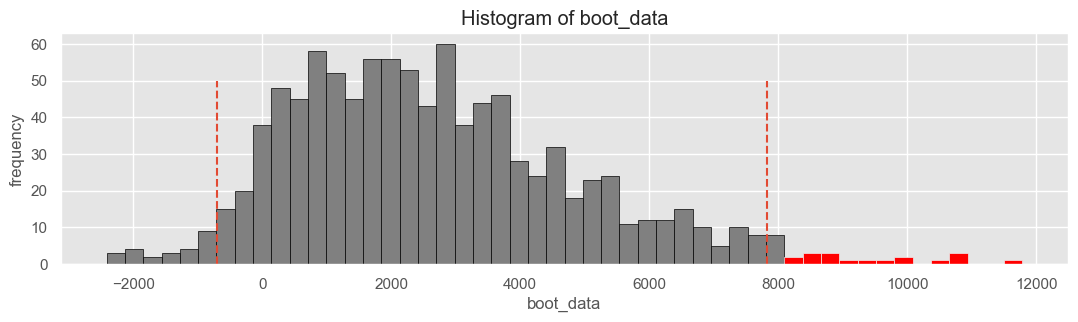

In [111]:
booted_data = get_bootstrap(sample_1, sample_2)

In [112]:
booted_data['quants']

,0
0.025,-701.462304
0.975,7820.878272


In [113]:
booted_data['p_value']

0.232067348849765

ARPU_premium

In [114]:
sample_1 = users_transactions_premium.query('group == "A1"').revenue
sample_2 = users_transactions_premium.query('group == "A2"').revenue

  0%|          | 0/1000 [00:00<?, ?it/s]

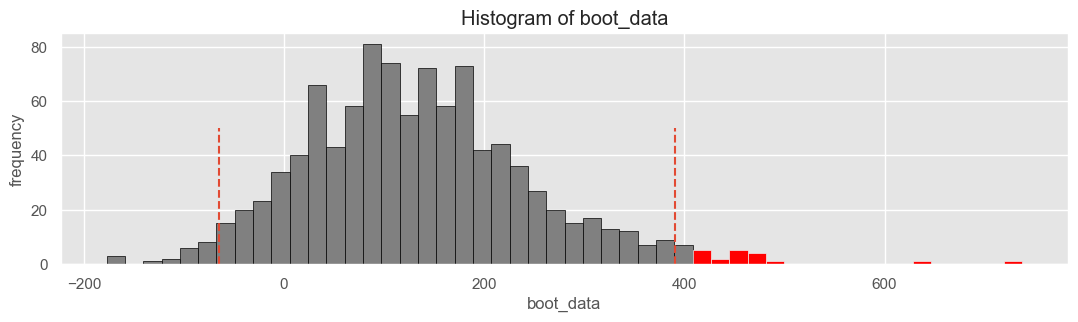

In [115]:
booted_data = get_bootstrap(sample_1, sample_2)

In [116]:
booted_data['quants']

,0
0.025,-64.992774
0.975,390.986666


In [117]:
booted_data['p_value']

0.23875131132987393

ARPPU_premium

In [118]:
transactions_ARPPU_premium = transactions.query('product_type == "premium_no_trial"')\
                    .groupby(['uid', 'group'], as_index=False)\
                    .agg(revenue=('revenue', 'sum'))[['uid', 'group', 'revenue']]

In [119]:
sample_1 = transactions_ARPPU_premium.query('group == "A1"').revenue
sample_2 = transactions_ARPPU_premium.query('group == "A2"').revenue

  0%|          | 0/1000 [00:00<?, ?it/s]

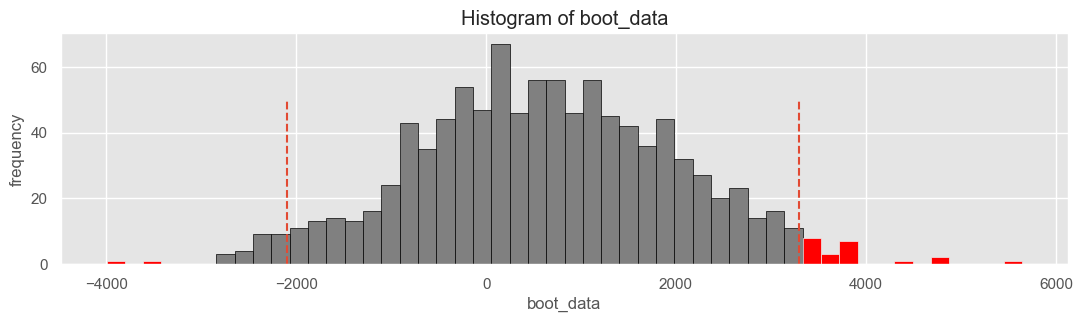

In [120]:
booted_data = get_bootstrap(sample_1, sample_2)

In [121]:
booted_data['quants']

,0
0.025,-2099.621078
0.975,3291.552206


In [122]:
booted_data['p_value']

0.646771098716491

Полученные значения p-value (> 0.05) позволяют сказать о том, что наши метрики в двух группах значимо не различаются

**Таким образом, можем считать А/А тестирование успешным - выборки однородны, проблем со сплитованием не выявлено. Переходим к А/В тесту**

### A/B тестирование

Объединим A1 и A2 в общую группу А

In [123]:
users_transactions.group = users_transactions.group.apply(lambda x:'B' if x == 'B' else 'A')
transactions.group = transactions.group.apply(lambda x:'B' if x == 'B' else 'A')

In [124]:
# проверим
print(users_transactions.group.value_counts())
print(transactions.group.value_counts())

A    8556
B    4271
Name: group, dtype: int64
A    675
B    266
Name: group, dtype: int64


Для оценки успешности эксперимента будем использовать метрики:
1. CR в премиум-подписку (premium_no_trial)<br />
2. ARPU & ARPPU
3. ARPU & ARPPU по premium_no_trial

**Будем использовать гипотезы:**

H0 - различия метрик в тестовой и контрольной группах статистически не значимы

H1 - различия метрик в тестовой и контрольной группах статистически значимы

Если p_value < 0.05, то отклоняем H0, принимаем H1

**1. CR в премиум-подписку**

In [125]:
# Проделаем то же, что и в А/А тестировании

# Для каждого пользователя отберем только первую покупку premium_no_trial
first_premium = transactions.query("product_type=='premium_no_trial'") \
    .groupby('uid', as_index=False) \
    .agg(first_premium=('paid_at', 'min'))

# Первую покупку premium_no_trial обозначим  как 1 
first_premium['purchase_premium'] = 1

# Объединим таблицы users и first_premium
users_transactions_premium = users_transactions.merge(first_premium, how='left', on='uid')

# Заменим пропущенные значения  в колонке 'purchase_premium' на 0
users_transactions_premium['purchase_premium'] = users_transactions_premium.purchase_premium.fillna(0)

users_transactions_premium.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,premium,is_premium,total_revenue,group,user_type,revenue,first_premium,purchase_premium
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,B,not_premium_not_pay,0.0,NaT,0.0
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,B,not_premium_not_pay,0.0,NaT,0.0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,B,not_premium_not_pay,0.0,NaT,0.0
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,B,not_premium_not_pay,0.0,NaT,0.0
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,B,premium_not_pay,0.0,NaT,0.0


In [126]:
# Посчитаем CR в %

conversion_control = users_transactions_premium.groupby('group', as_index=False) \
    .agg({'purchase_premium': 'mean'}) \
    .rename(columns={'purchase_premium': 'conversion'})

conversion_control['conversion'] = conversion_control.conversion.apply(lambda x: round(x * 100, 3))
conversion_control

,group,conversion
0,A,2.338
1,B,1.545


CR в премиум-подписку снизилась, проверим статистическую значимость отличий. Используем хи-квадрат.

In [127]:
# таблица сопряженности

tabAB = pd.crosstab(users_transactions_premium.purchase_premium, users_transactions_premium.group)
tabAB

group,A,B
purchase_premium,,
0.0,8356,4205
1.0,200,66


In [128]:
g, p, dof, expctd = chi2_contingency(tabAB)
print('р уровень значимости равен:', p)

р уровень значимости равен: 0.0037128442751454744


Результат < 0.05, значит, принимаем гипотезу H1, что снижение CR статистически значимо.

**2. ARPU и ARPPU в тестовой и контрольной группах**

In [129]:
ARPU = users_transactions.groupby('group', as_index=False).agg(ARPU=('revenue', 'mean'))
ARPU['ARPU'] = ARPU.ARPU.apply(lambda x: round(x, 3))
ARPU

,group,ARPU
0,A,508.041
1,B,543.915


In [130]:
ARPPU = transactions.groupby('group', as_index=False).agg(ARPPU=('revenue', 'mean'))
ARPPU['ARPPU'] = ARPPU.ARPPU.apply(lambda x: round(x, 3))
ARPPU

,group,ARPPU
0,A,6476.639
1,B,8767.767


Результ: ARPU почти одинаковы, а ARPPU - в тестовой группе - выше. Проверим статистическую значимость различий

In [132]:
# проверяем нормальность распределения
transactions_A = transactions.query('group == "A"').revenue
stats.normaltest(transactions_A)

NormaltestResult(statistic=735.6975707750961, pvalue=1.759147807493101e-160)

In [133]:
# проверяем нормальность распределения
transactions_B = transactions.query('group == "B"').revenue
stats.normaltest(transactions_B)

NormaltestResult(statistic=366.6554623544979, pvalue=2.408673695689808e-80)

In [ ]:
# проверяем гомогенность
scipy.stats.levene(transactions.query('group == "A"').revenue, 
          transactions.query('group == "B"').revenue, center='mean')

Полученные результаты говорят о ненормальности распределения в группах и неравенстве дисперсий

Проверим значимость отличий ARPU и ARPPU с помощью бутстрапа. Будем использовать ранее объявленную функцию

**Гипотезы** <br>

Н0 - "средние чеки" (на пользователя - ARPU и платящего пользователя - ARPPU) в группах статистически не отличаются

Н1 - ARPPU и ARPU в группах отличаются <br> 

**ARPU**

In [ ]:
sample_1 = users_transactions.query('group == "A"').revenue
sample_2 = users_transactions.query('group == "B"').revenue

In [ ]:
booted_data = get_bootstrap(sample_1, sample_2)  # в результате хранится разница двух распределений, доверительные интервалы и pvalue

In [ ]:
booted_data['quants']

In [ ]:
booted_data['p_value']

**ARPPU**

In [ ]:
transactions_ARPPU = transactions.groupby(['uid', 'group'], as_index=False).agg(revenue=('revenue', 'sum'))[['uid', 'group', 'revenue']]
sample_1 = transactions_ARPPU.query('group == "A"').revenue
sample_2 = transactions_ARPPU.query('group == "B"').revenue

In [ ]:
booted_data = get_bootstrap(sample_1, sample_2)  # в результате хранится разница двух распределений, доверительные интервалы и pvalue

In [ ]:
booted_data['quants']

In [ ]:
booted_data['p_value']

Полученные значения p-value позволяют сказать о том, что для ARPU мы не отвергаем гипотезу H0 (значит, различия статистически не значимы), но ARPPU - мы принимаем гипотезу H1 (увеличение ARPPU статистически значимо)

**2. ARPU и ARPPU по premium_no_trial в тестовой и контрольной группах**

ARPU_premium

In [ ]:
ARPU_premium = users_transactions_premium.query('purchase_premium == 1').groupby('group', as_index=False).agg(ARPU=('revenue', 'mean'))
ARPU_premium['ARPU'] = ARPU_premium.ARPU.apply(lambda x: round(x, 3))
ARPU_premium

ARRPU_premium

In [ ]:
ARPPU_premium = transactions.query('product_type == "premium_no_trial"').groupby('group', as_index=False).agg(ARPPU=('revenue', 'mean'))
ARPPU_premium['ARPPU'] = ARPPU_premium.ARPPU.apply(lambda x: round(x, 3))
ARPPU_premium

Результат: ARPU и ARPPU премиум в тестовой группе выше. Проверим статистическую значимость различий

ARPU_premium

In [ ]:
sample_1 = users_transactions_premium.query('group == "A"').revenue
sample_2 = users_transactions_premium.query('group == "B"').revenue

In [ ]:
booted_data = get_bootstrap(sample_1, sample_2)

In [ ]:
booted_data['quants']

In [ ]:
booted_data['p_value']

ARPPU_premium

In [ ]:
transactions_ARPPU_premium = transactions.query('product_type == "premium_no_trial"')\
                    .groupby(['uid', 'group'], as_index=False)\
                    .agg(revenue=('revenue', 'sum'))[['uid', 'group', 'revenue']]

In [ ]:
sample_1 = transactions_ARPPU_premium.query('group == "A"').revenue
sample_2 = transactions_ARPPU_premium.query('group == "B"').revenue

In [ ]:
booted_data = get_bootstrap(sample_1, sample_2)

In [ ]:
booted_data['quants']

In [ ]:
booted_data['p_value']

Полученные значения p-value позволяют сказать о том, что для ARPU_premium мы не отвергаем гипотезу H0 (значит, различия статистически не значимы), но ARPPU_premium - мы принимаем гипотезу H1 (увеличение ARPPU статистически значимо)

Таким образом, мы можем говорить об увеличение выручки на 1 платящего как по всем продуктам, так и по покупке премиум-подписки (без использования пробной)

### Выводы

Эксперимент с изменением стоимости премиум-подписки показал следующее:
  - Конверсия в премиум-подписку (CR) снизилась;
  - Показатели ARPPU увеличился

Таким образом, с одной стороны, 

эксперимент можно назвать удачным (если хотим ориентироваться только на полученные результаты по ARPPU),

а с другой стороны - конверсия снизилась - подписчики не стремятся приобретать премиум-подписку, и поведение пользователей вряд ли кардинально изменится.

Поэтому можем предположить, что увеличение выручки компенсировало сниженную конверсию. Вопрос - надолго ли?

Возможно, в отдельных группах пользователей нововведение и принесет пользу, но в целом считаю проведенный эксперимент неуспешным. 